# **Klasifikasi Gambar Sampah organik dan anorganik**


## **Sumber Dataset**
https://www.kaggle.com/datasets/techsash/waste-classification-data

## Import Semua Packages/Library yang Digunakan

In [27]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import GlobalAveragePooling2D
from google.colab import drive
from google.colab import files
import PIL
import albumentations as A
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import load_model
import tensorflow.lite as tflite
import joblib
import pickle
from collections import Counter

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
# Upload file kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"synjoestar","key":"cc2ece4b04fbbc8f0bf1e1d15c24c861"}'}

In [4]:
# Hapus dataset lama jika ada
!rm -rf waste_classification_data/ waste-classification-data.zip

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d techsash/waste-classification-data

# Unzip dataset ke dalam folder waste_classification_data
!unzip -q waste-classification-data.zip -d waste_classification_data

# Hapus file zip untuk menghemat penyimpanan
!rm waste-classification-data.zip

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 97% 415M/427M [00:04<00:00, 113MB/s]
100% 427M/427M [00:04<00:00, 110MB/s]


In [8]:
# Path dataset utama
dataset_path = "/content/waste_classification_data/DATASET"
train_path = os.path.join(dataset_path, "TRAIN")
test_path = os.path.join(dataset_path, "TEST")

# List kelas dalam dataset
classes = [c for c in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, c))]

print(f"Jumlah kelas yang valid: {len(classes)}")
print(f"Kelas yang tersedia: {classes}")

# Cek jumlah gambar per kelas di TRAIN dan TEST
for split, path in zip(["TRAIN", "TEST"], [train_path, test_path]):
    print(f"\nDataset: {split}")
    for c in classes:
        num_images = len(os.listdir(os.path.join(path, c)))
        print(f"Kelas {c}: {num_images} gambar")

# Cek apakah semua gambar valid di TRAIN dan TEST
for split, path in zip(["TRAIN", "TEST"], [train_path, test_path]):
    print(f"\nMemeriksa gambar di {split}...")
    for c in classes:
        class_path = os.path.join(path, c)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Cek validitas gambar
            except Exception as e:
                print(f"Masalah dengan {img_path}: {e}")


Jumlah kelas yang valid: 2
Kelas yang tersedia: ['R', 'O']

Dataset: TRAIN
Kelas R: 9999 gambar
Kelas O: 12565 gambar

Dataset: TEST
Kelas R: 1112 gambar
Kelas O: 1401 gambar

Memeriksa gambar di TRAIN...

Memeriksa gambar di TEST...


In [9]:
def check_images(path, classes):
    print(f"\nMemeriksa gambar di {path}...")
    for c in classes:
        class_path = os.path.join(path, c)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Cek file corrupt
                img = Image.open(img_path).convert("RGB")  # Pastikan bisa dibaca ulang
                img.resize((224, 224))  # Resize untuk simulasi preprosesing
            except Exception as e:
                print(f"❌ Masalah dengan {img_path}: {e}")

check_images(train_path, classes)
check_images(test_path, classes)



Memeriksa gambar di /content/waste_classification_data/DATASET/TRAIN...

Memeriksa gambar di /content/waste_classification_data/DATASET/TEST...


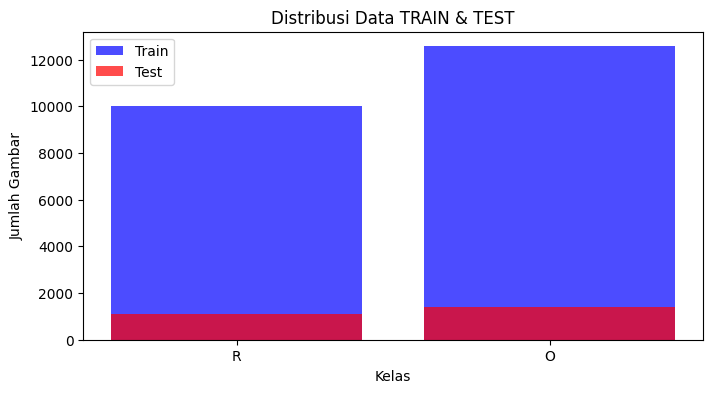

In [11]:
# Cek distribusi data
train_counts = [len(os.listdir(os.path.join(train_path, c))) for c in classes]
test_counts = [len(os.listdir(os.path.join(test_path, c))) for c in classes]

plt.figure(figsize=(8, 4))
plt.bar(classes, train_counts, color='blue', alpha=0.7, label="Train")
plt.bar(classes, test_counts, color='red', alpha=0.7, label="Test")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Data TRAIN & TEST")
plt.legend()
plt.show()


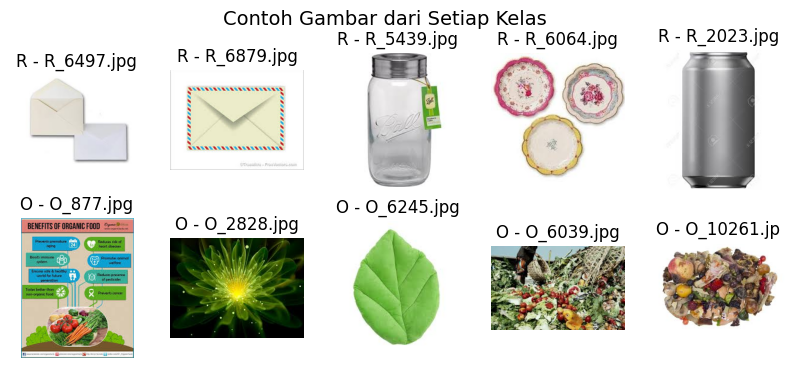

In [13]:
# Fungsi untuk menampilkan sample gambar dari setiap kelas
def show_sample_images(path, classes, num_samples=5):
    fig, axes = plt.subplots(nrows=len(classes), ncols=num_samples, figsize=(num_samples * 2, len(classes) * 2))

    for i, c in enumerate(classes):
        class_path = os.path.join(path, c)
        sample_images = random.sample(os.listdir(class_path), num_samples)  # Ambil 5 gambar random
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{c} - {img_name[:10]}")

    plt.suptitle("Contoh Gambar dari Setiap Kelas", fontsize=14)
    plt.show()

# Tampilkan sample gambar dari TRAIN set
show_sample_images(train_path, classes, num_samples=5)


### Data Preprocessing

#### Split Dataset

In [14]:
# Path dataset utama
dataset_path = "/content/waste_classification_data/DATASET"
train_source_path = os.path.join(dataset_path, "TRAIN")
test_source_path = os.path.join(dataset_path, "TEST")

# Path dataset baru
train_path = "/content/dataset/train"
val_path = "/content/dataset/val"
test_path = "/content/dataset/test"

# Buat folder train, val, test
for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)

# Fungsi preprocessing dengan OpenCV
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscale

    # Gaussian Blur untuk stabilisasi
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # Canny Edge Detection
    edges = cv2.Canny(img_blur, 50, 150)

    # Watershed segmentation
    ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Label markers
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Warna merah untuk boundary

    return img

# Split dataset dari TRAIN
for category in os.listdir(train_source_path):
    class_path = os.path.join(train_source_path, category)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        if len(images) > 1:
            # **Perbaikan split: Train 80%, Val 10%, Test 10%**
            train_images, temp_images = train_test_split(images, test_size=0.20, random_state=42)
            val_images, test_images = train_test_split(temp_images, test_size=0.50, random_state=42)
        else:
            train_images, val_images, test_images = images, [], []

        # Buat folder per kelas
        for path in [train_path, val_path, test_path]:
            os.makedirs(os.path.join(path, category), exist_ok=True)

        # Pindahkan gambar ke folder masing-masing
        for img in train_images:
            img_path = os.path.join(class_path, img)
            cv2.imwrite(os.path.join(train_path, category, img), cv2.imread(img_path))
        for img in val_images:
            img_path = os.path.join(class_path, img)
            cv2.imwrite(os.path.join(val_path, category, img), cv2.imread(img_path))
        for img in test_images:
            img_path = os.path.join(class_path, img)
            cv2.imwrite(os.path.join(test_path, category, img), cv2.imread(img_path))

print("✅ Dataset berhasil diproses! Train: 80%, Val: 10%, Test: 10%.")



✅ Dataset berhasil diproses! Train: 80%, Val: 10%, Test: 10%.


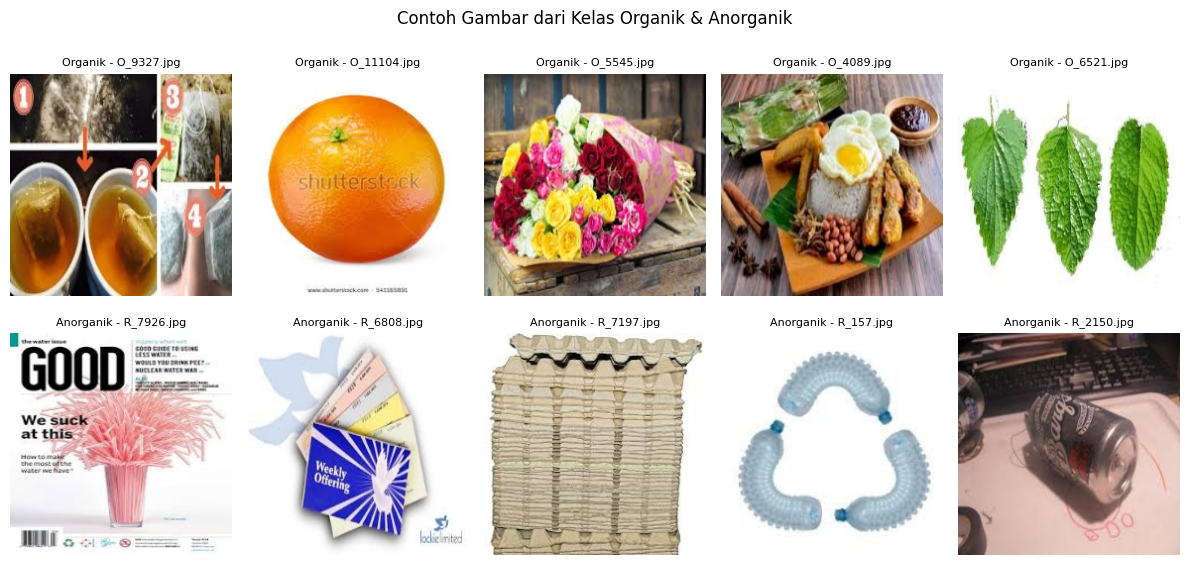

In [18]:
# Path dataset setelah split
train_path = "/content/dataset/train"

# Kategori yang lebih jelas
categories = {"O": "Organik", "R": "Anorganik"}

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, (short_label, full_label) in enumerate(categories.items()):
    class_path = os.path.join(train_path, short_label)

    # Cek jika folder ada
    if not os.path.exists(class_path):
        print(f"Folder {class_path} tidak ditemukan!")
        continue  # Skip kalau folder tidak ada

    images = os.listdir(class_path)
    selected_images = random.sample(images, min(5, len(images)))  # Ambil max 5 gambar, kalau kurang ya ambil yang ada

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize biar konsisten

        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{full_label} - {img_name}", fontsize=8)

plt.suptitle("Contoh Gambar dari Kelas Organik & Anorganik", fontsize=12)
plt.tight_layout()
plt.show()


#### Augmentasi

In [51]:
#########################################
# 1. Augmentasi Manual
#########################################
# Path Dataset
original_path = "/content/dataset/train/"  # Gunakan dataset train untuk augmentasi
augmented_path = "/content/dataset/train_augmented/"  # Simpan hasil augmentasi di sini

os.makedirs(augmented_path, exist_ok=True)

# Fungsi Augmentasi Manual
def blur_image(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def rotate_random(img):
    angle = random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE])
    return cv2.rotate(img, angle)

def warp_shift(img):
    rows, cols, _ = img.shape
    src_points = np.float32([[0, 0], [cols, 0], [0, rows]])
    dst_points = np.float32([[cols * 0.1, rows * 0.2], [cols * 0.9, 0], [cols * 0.2, rows]])
    M = cv2.getAffineTransform(src_points, dst_points)
    return cv2.warpAffine(img, M, (cols, rows))

# Proses Augmentasi & Simpan
for class_folder in os.listdir(original_path):  # Loop untuk setiap kelas
    class_path = os.path.join(original_path, class_folder)
    if not os.path.isdir(class_path):
        continue

    # Buat folder di augmented_path untuk kelas ini
    class_aug_path = os.path.join(augmented_path, class_folder)
    os.makedirs(class_aug_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"File {img_path} tidak bisa dibaca, dilewati.")
            continue

        # Terapkan augmentasi
        augmented_images = [
            blur_image(img),
            rotate_random(img),
            warp_shift(img)
        ]
        # Simpan hasil augmentasi
        for i, aug_img in enumerate(augmented_images):
            aug_img_path = os.path.join(class_aug_path, f"{img_name.split('.')[0]}_aug_{i}.jpg")
            cv2.imwrite(aug_img_path, img_as_ubyte(aug_img))

print("Proses augmentasi selesai!")

Proses augmentasi selesai!


## ImageDataGenerator

In [52]:
#########################################
# 2. Data Generator Setup (untuk training, validasi, test)
#########################################
# Path dataset yang sudah dipisah
TRAIN_DIR = "/content/dataset/train/"
VALID_DIR = "/content/dataset/val/"
TEST_DIR = "/content/dataset/test/"

# Data Augmentation untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasi & Test hanya normalisasi
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='binary',
    shuffle=True
)

# Validation Generator
validation_generator = valid_test_datagen.flow_from_directory(
    VALID_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='binary',
    shuffle=False
)

# Test Generator
test_generator = valid_test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='binary',
    shuffle=False
)

print("Total gambar di Training set:", train_generator.samples)
print("Total gambar di Validation set:", validation_generator.samples)
print("Total gambar di Test set:", test_generator.samples)
print("Data preprocessing selesai! Siap ke tahap training 🚀")


Found 18051 images belonging to 2 classes.
Found 2256 images belonging to 2 classes.
Found 2257 images belonging to 2 classes.
Total gambar di Training set: 18051
Total gambar di Validation set: 2256
Total gambar di Test set: 2257
Data preprocessing selesai! Siap ke tahap training 🚀


## Modelling

In [23]:
# Setup Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, mode='min', min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode='min', verbose=1)

# Callback untuk TensorBoard (opsional)
log_dir = "logs"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

# Gabungkan semua callback
callbacks = [early_stopping, reduce_lr, model_checkpoint, tensorboard_callback]

In [53]:
#########################################
# 3. Build & Compile Model
#########################################
# Load MobileNetV2 tanpa fully connected layer terakhir
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model untuk fase awal

# Tambahkan custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,427,201 (9.26 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [54]:
# Hitung jumlah gambar per kelas
count_organik = len(os.listdir(os.path.join(TRAIN_DIR, "O")))
count_anorganik = len(os.listdir(os.path.join(TRAIN_DIR, "R")))

# Hitung class weights
weight_organik = (1 / count_organik) * (count_organik + count_anorganik) / 2.0
weight_anorganik = (1 / count_anorganik) * (count_anorganik + count_organik) / 2.0
class_weights = {0: weight_organik, 1: weight_anorganik}
print(class_weights)

{0: 0.8978810187027457, 1: 1.1283285410676336}


In [55]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    class_weight=class_weights,  # Gunakan class weights
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7966 - loss: 0.5017
Epoch 1: val_loss improved from inf to 0.23402, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 228s 382ms/step - accuracy: 0.7967 - loss: 0.5015 - val_accuracy: 0.9105 - val_loss: 0.2340 - learning_rate: 1.0000e-04
Epoch 2/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8992 - loss: 0.2593
Epoch 2: val_loss improved from 0.23402 to 0.20777, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 207s 367ms/step - accuracy: 0.8992 - loss: 0.2593 - val_accuracy: 0.9193 - val_loss: 0.2078 - learning_rate: 1.0000e-04
Epoch 3/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9078 - loss: 0.2291
Epoch 3: val_loss improved from 0.20777 to 0.20033, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 264s 370ms/step - accuracy: 0.9078 - loss: 0.2291 - val_accuracy: 0.9246 - val_loss: 0.2003 - learning_rate: 1.0000e-04
Epoch 4/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9166 - loss: 0.2113
Epoch 4: val_loss improved from 0.20033 to 0.19109, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 209s 369ms/step - accuracy: 0.9166 - loss: 0.2113 - val_accuracy: 0.9260 - val_loss: 0.1911 - learning_rate: 1.0000e-04
Epoch 5/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9207 - loss: 0.1997
Epoch 5: val_loss improved from 0.19109 to 0.18498, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 208s 369ms/step - accuracy: 0.9207 - loss: 0.1997 - val_accuracy: 0.9291 - val_loss: 0.1850 - learning_rate: 1.0000e-04
Epoch 6/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9180 - loss: 0.2052
Epoch 6: val_loss improved from 0.18498 to 0.18362, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 211s 373ms/step - accuracy: 0.9180 - loss: 0.2052 - val_accuracy: 0.9304 - val_loss: 0.1836 - learning_rate: 1.0000e-04
Epoch 7/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9203 - loss: 0.1971
Epoch 7: val_loss improved from 0.18362 to 0.17645, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 213s 377ms/step - accuracy: 0.9203 - loss: 0.1971 - val_accuracy: 0.9300 - val_loss: 0.1764 - learning_rate: 1.0000e-04
Epoch 8/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9321 - loss: 0.1812
Epoch 8: val_loss did not improve from 0.17645
565/565 ━━━━━━━━━━━━━━━━━━━━ 211s 373ms/step - accuracy: 0.9321 - loss: 0.1812 - val_accuracy: 0.9326 - val_loss: 0.1803 - learning_rate: 1.0000e-04
Epoch 9/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9309 - loss: 0.1768
Epoch 9: val_loss improved from 0.17645 to 0.16767, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 210s 372ms/step - accuracy: 0.9309 - loss: 0.1768 - val_accuracy: 0.9388 - val_loss: 0.1677 - learning_rate: 1.0000e-04
Epoch 10/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9298 - loss: 0.1772
Epoch 10: val_loss did not improve from 0.16767
565/565 ━━━━━━━━━━━━━━━━━━━━ 211s 373ms/step - accuracy: 0.9298 - loss: 0.1772 - val_accuracy: 0.9344 - val_loss: 0.1715 - learning_rate: 1.0000e-04
Epoch 11/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9337 - loss: 0.1698
Epoch 11: val_loss did not improve from 0.16767
565/565 ━━━━━━━━━━━━━━━━━━━━ 211s 373ms/step - accuracy: 0.9337 - loss: 0.1698 - val_accuracy: 0.9371 - val_loss: 0.1685 - learning_rate: 1.0000e-04
Epoch 12/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9332 - loss: 0.1624
Epoch 12: val_loss improved from 0.16767 to 0.16468, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 211s 373ms/step - accuracy: 0.9332 - loss: 0.1624 - val_accuracy: 0.9415 - val_loss: 0.1647 - learning_rate: 1.0000e-04
Epoch 13/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9350 - loss: 0.1634
Epoch 13: val_loss improved from 0.16468 to 0.16321, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 263s 376ms/step - accuracy: 0.9350 - loss: 0.1634 - val_accuracy: 0.9406 - val_loss: 0.1632 - learning_rate: 1.0000e-04
Epoch 14/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9378 - loss: 0.1632
Epoch 14: val_loss improved from 0.16321 to 0.16050, saving model to best_model.h5


565/565 ━━━━━━━━━━━━━━━━━━━━ 260s 373ms/step - accuracy: 0.9378 - loss: 0.1632 - val_accuracy: 0.9450 - val_loss: 0.1605 - learning_rate: 1.0000e-04
Epoch 15/15
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9374 - loss: 0.1560
Epoch 15: val_loss did not improve from 0.16050
565/565 ━━━━━━━━━━━━━━━━━━━━ 214s 378ms/step - accuracy: 0.9374 - loss: 0.1560 - val_accuracy: 0.9402 - val_loss: 0.1619 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 14.


In [57]:
# Muat model yang sudah disimpan sebelumnya
model = tf.keras.models.load_model("best_model.h5")

# Bungkus model dengan class agar bisa disimpan dalam Pickle/Joblib
class KerasModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict(X)

# Simpan ke Pickle
wrapped_model = KerasModelWrapper(model)
joblib.dump(wrapped_model, "model.pkl")
print("Model disimpan sebagai model.pkl menggunakan Joblib.")

Model disimpan sebagai model.pkl menggunakan Joblib.


## Evaluasi dan Visualisasi

2257/2257 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
Classification Report:

                  precision    recall  f1-score   support

Sampah Anorganik     0.9658    0.9427    0.9541      1257
  Sampah Organik     0.9301    0.9580    0.9438      1000

        accuracy                         0.9495      2257
       macro avg     0.9479    0.9504    0.9490      2257
    weighted avg     0.9500    0.9495    0.9496      2257



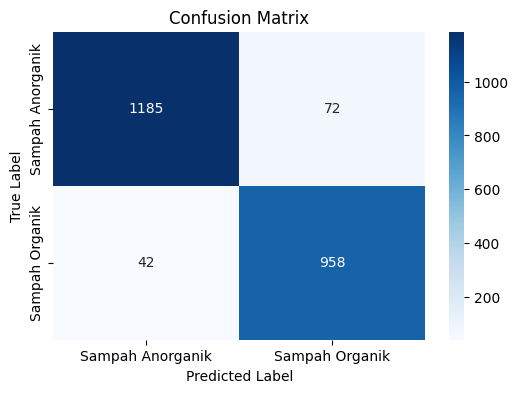

In [56]:
# Pastikan test_generator sudah di-reset
test_generator.reset()

# Lakukan prediksi pada test set
predictions = model.predict(test_generator, verbose=1)

# Karena model binary, kita gunakan threshold 0.5
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

# Tampilkan classification report
target_names = ['Sampah Anorganik', 'Sampah Organik']
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=target_names, digits=4))

# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

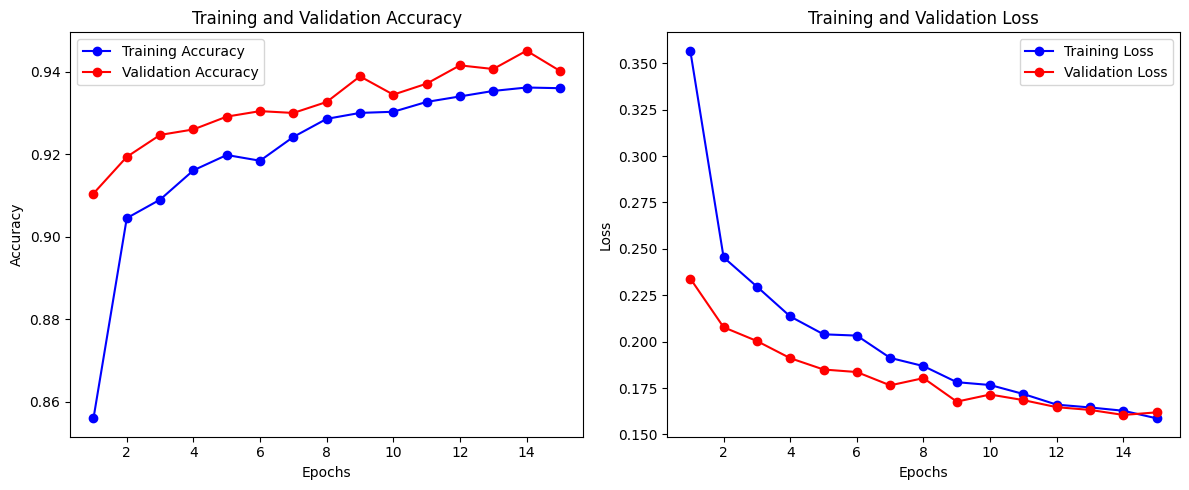

In [58]:
# Visualisasi grafik training (akurasi & loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

#### SavedModel


In [60]:
# Gunakan model.export() untuk menyimpan model dalam format SavedModel
model.export("saved_model_trashlab")
print("Model berhasil disimpan sebagai SavedModel di 'saved_model_trashlab'.")

Saved artifact at 'saved_model_trashlab'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138313192575568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192571728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192576720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192573072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192582288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192581520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192579792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192572688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192580752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192578256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138313192

## Inference

In [61]:
# Di Keras 3, untuk memuat SavedModel sebagai inference-only layer, gunakan TFSMLayer:
loaded_model = tf.keras.layers.TFSMLayer("saved_model_trashlab", call_endpoint="serving_default")
print("Model berhasil dimuat untuk inference.")

Model berhasil dimuat untuk inference.


In [70]:
# Fungsi preprocessing gambar
def preprocess_image(image_path):
    img = cv2.imread(image_path)  # Baca gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, (224, 224))  # Sesuaikan ukuran dengan model
    img = img / 255.0  # Normalisasi ke range [0,1]
    img = np.expand_dims(img, axis=0).astype(np.float32)  # Pastikan dimensi sesuai
    return img

# Fungsi Prediksi
def predict_savedmodel(image_path):
    img = preprocess_image(image_path)
    prediction = loaded_model(img)

    # Jika output berbentuk dictionary, ambil key yang benar
    if isinstance(prediction, dict):
        prediction = list(prediction.values())[0]

    # Jika output berbentuk tensor, konversi ke numpy
    if isinstance(prediction, tf.Tensor):
        prediction = prediction.numpy()

    print("Output Model:", prediction)  # Debugging

    # **Mapping sesuai class_indices**
    label = "Organik" if prediction[0][0] < 0.5 else "Anorganik"
    confidence = 1 - prediction[0][0] if label == "Organik" else prediction[0][0]

    return label, confidence


# Contoh penggunaan
image_path = "/content/1.jpg"
label, confidence = predict_savedmodel(image_path)
print(f"Prediksi: {label} (Confidence: {confidence:.2f})")

Output Model: [[0.9997726]]
Prediksi: Anorganik (Confidence: 1.00)


In [69]:
print(train_generator.class_indices)

{'O': 0, 'R': 1}
